In [1]:
from Simulation.sys_ids import *
import pickle

## Generate step test data for system identification

In [2]:
# First initiate the system
# Parameters
Ad = 2.142e17           # h^-1
Ed = 14897              # K
Ap = 3.816e10           # L/(molh)
Ep = 3557               # K
At = 4.50e12            # L/(molh)
Et = 843                # K
fi = 0.6                # Coefficient
m_delta_H_r = -6.99e4   # j/mol
hA = 1.05e6             # j/(Kh)
rhocp = 1506            # j/(Kh)
rhoccpc = 4043          # j/(Kh)
Mm = 104.14             # g/mol
system_params = np.array([Ad, Ed, Ap, Ep, At, Et, fi, m_delta_H_r, hA, rhocp, rhoccpc, Mm])

In [3]:
# Design Parameters
CIf = 0.5888    # mol/L
CMf = 8.6981    # mol/L
Qi = 108.       # L/h
Qs = 459.       # L/h
Tf = 330.       # K
Tcf = 295.      # K
V = 3000.       # L
Vc = 3312.4     # L
        
system_design_params = np.array([CIf, CMf, Qi, Qs, Tf, Tcf, V, Vc])

In [4]:
# Steady State Inputs
Qm_ss = 378.    # L/h
Qc_ss = 471.6   # L/h

system_steady_state_inputs = np.array([Qc_ss, Qm_ss])

In [5]:
# Sampling time of the system
delta_t = 0.5 # 30 mins

In [20]:
# Initiate the CSTR for steady state values
cstr = PolymerCSTR(system_params, system_design_params, system_steady_state_inputs, delta_t)
steady_states={"ss_inputs":cstr.ss_inputs,
               "y_ss":cstr.y_ss}

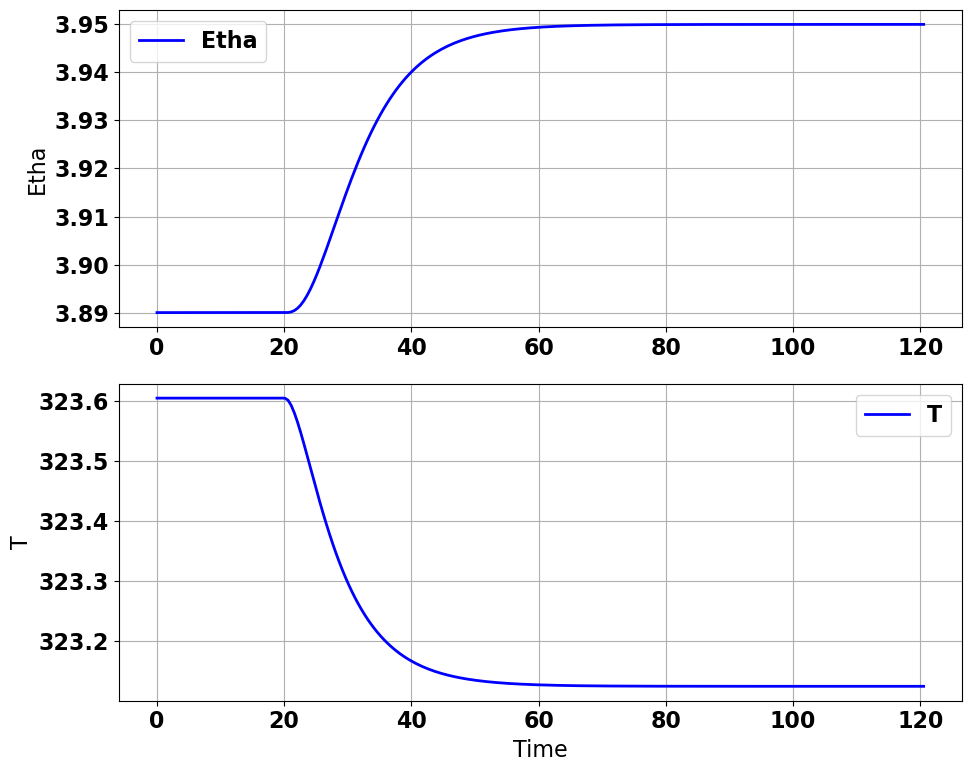

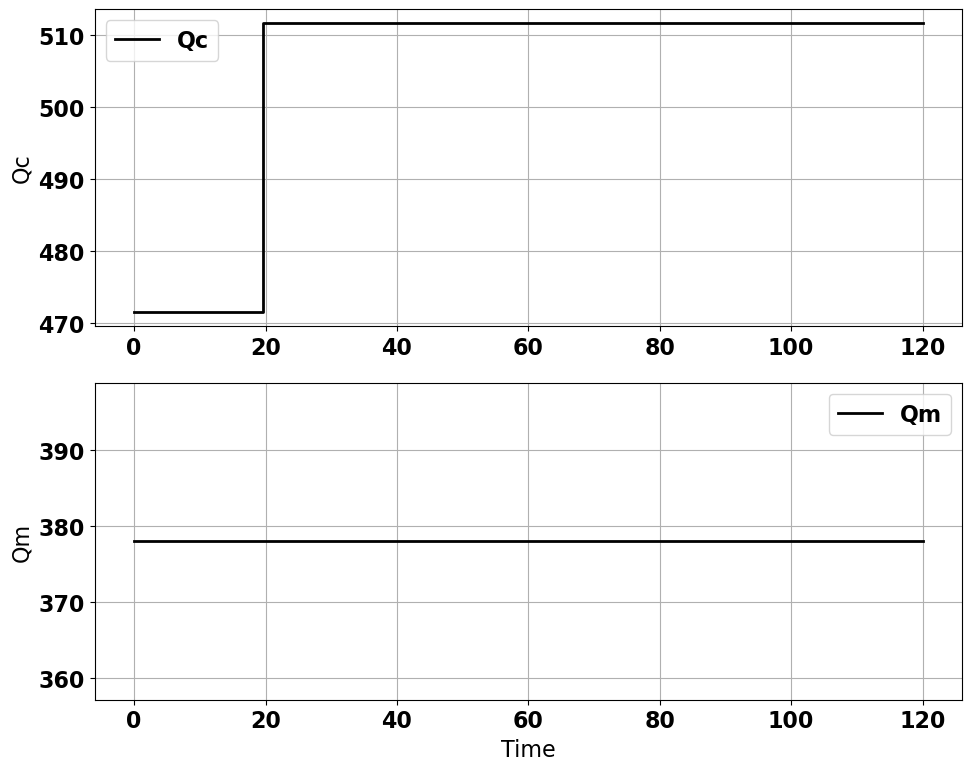

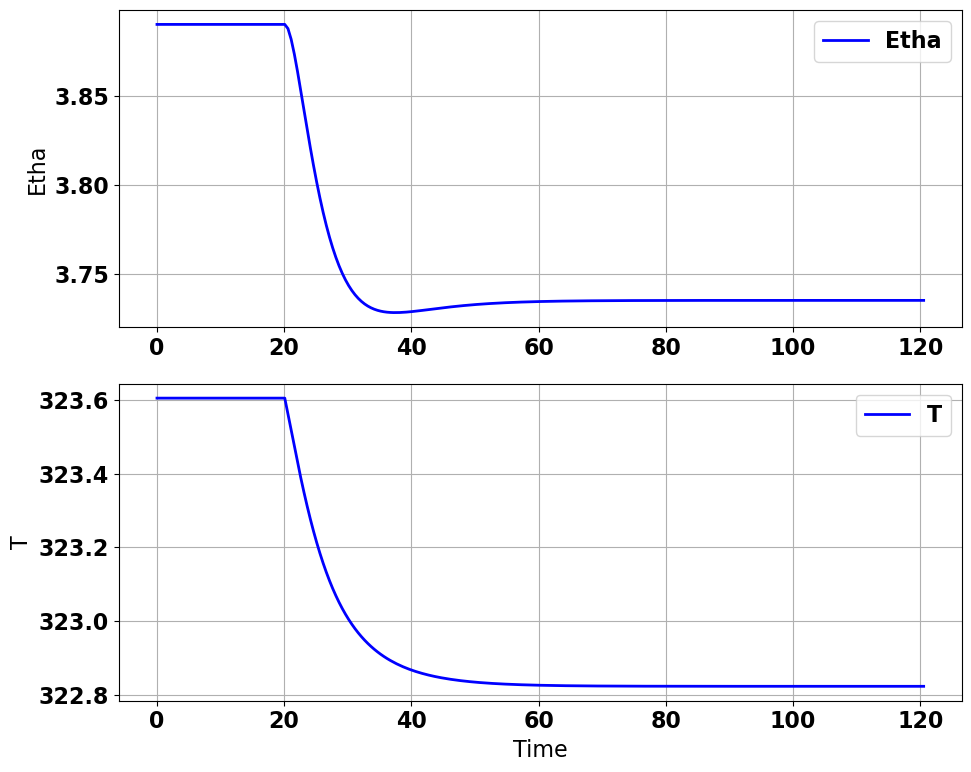

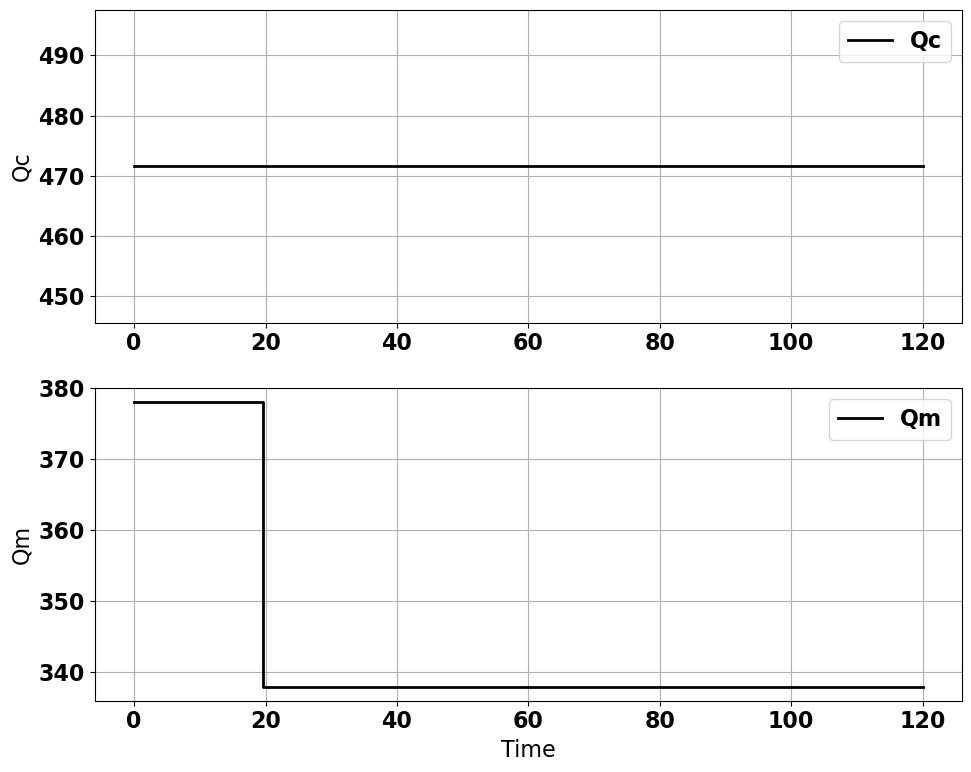

In [21]:
# Run Experiment 1
results_exp1 = run_cstr_experiment(step_value=40, step_channel=0, save_filename="Qc.csv",
                                   system_params=system_params, system_design_params=system_design_params,
                                   system_steady_state_inputs=system_steady_state_inputs, delta_t=delta_t)

# Run Experiment 2
results_exp2 = run_cstr_experiment(step_value=-40, step_channel=1, save_filename="Qm.csv",
                                   system_params=system_params, system_design_params=system_design_params,
                                   system_steady_state_inputs=system_steady_state_inputs, delta_t=delta_t)


In [22]:
data_dir = os.path.join(os.getcwd(), 'Data')
Qc_path = os.path.join(data_dir, "Qc.csv")
Qm_path = os.path.join(data_dir, "Qm.csv")

# Apply deviation form to both datasets:
file_paths = {"Qc": Qc_path, "Qm": Qm_path}
data_min, data_max = scaling_min_max_factors(file_paths)

In [23]:
deviation_dfs = apply_deviation_form_scaled(steady_states, file_paths, data_min, data_max)

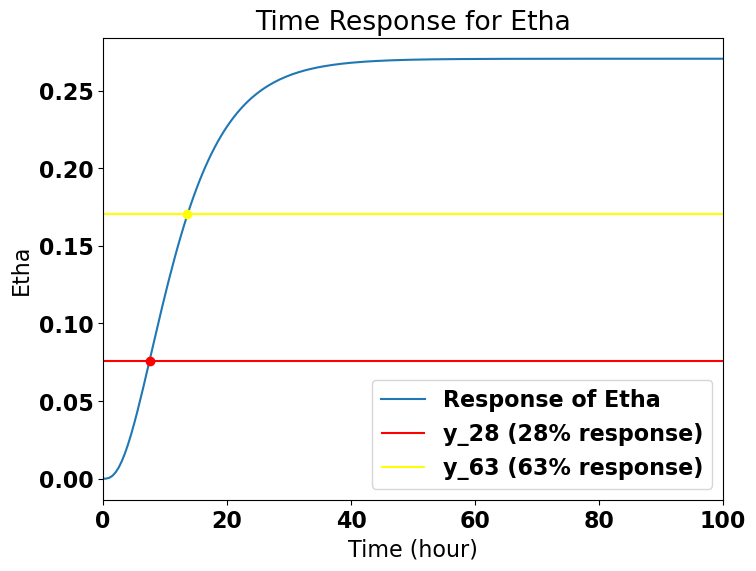

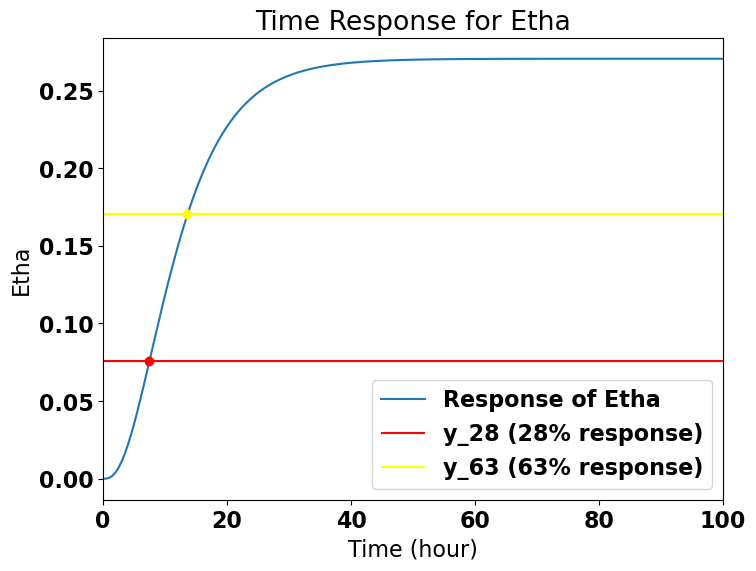

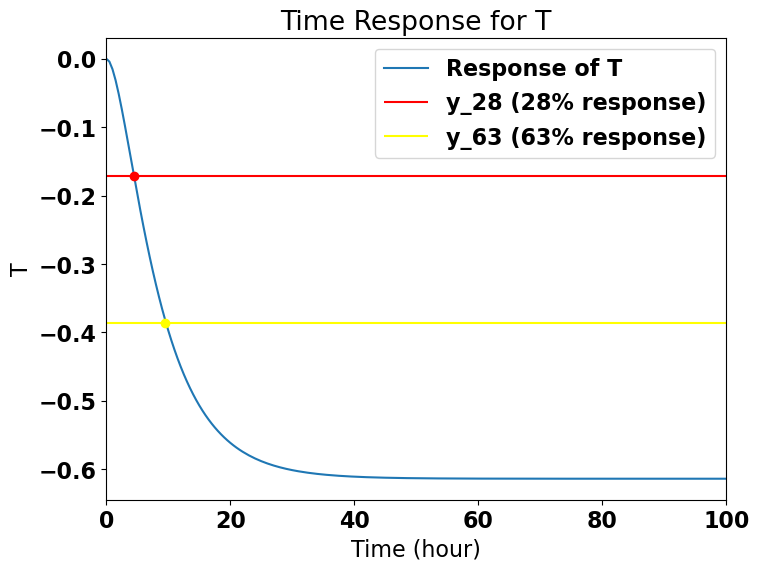

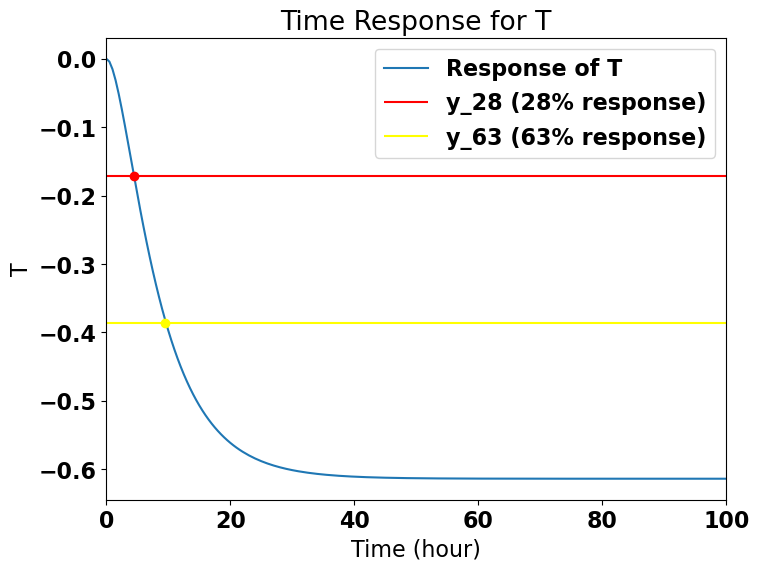


Transfer Function details for input mode "Qc":
Etha: {'Time 63 (hrs)': 13.5, 'Time 28 (hrs)': 7.45, 'kp': 0.27052707058097125, 'taup': 9.075, 'theta': 1.4000000000000004}
T: {'Time 63 (hrs)': 9.55, 'Time 28 (hrs)': 4.5, 'kp': -0.6138687960587834, 'taup': 7.575000000000001, 'theta': -0.5500000000000007}


In [24]:
Qc_dict, Qc_data = data_time28_63_dict(deviation_dfs["Qc"], mode=0, sampling_period=0.5)

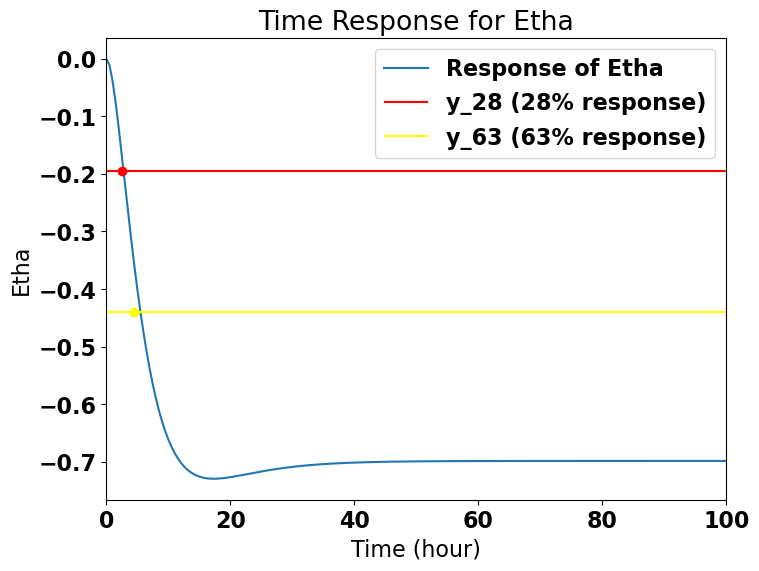

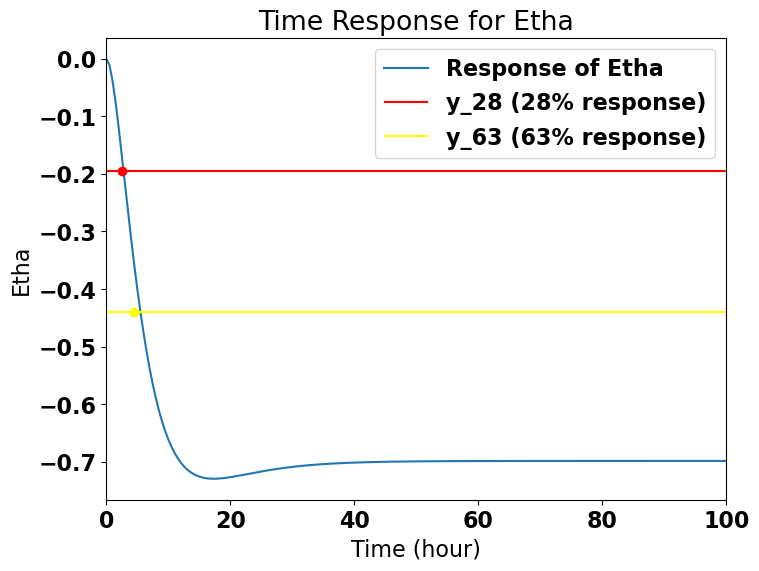

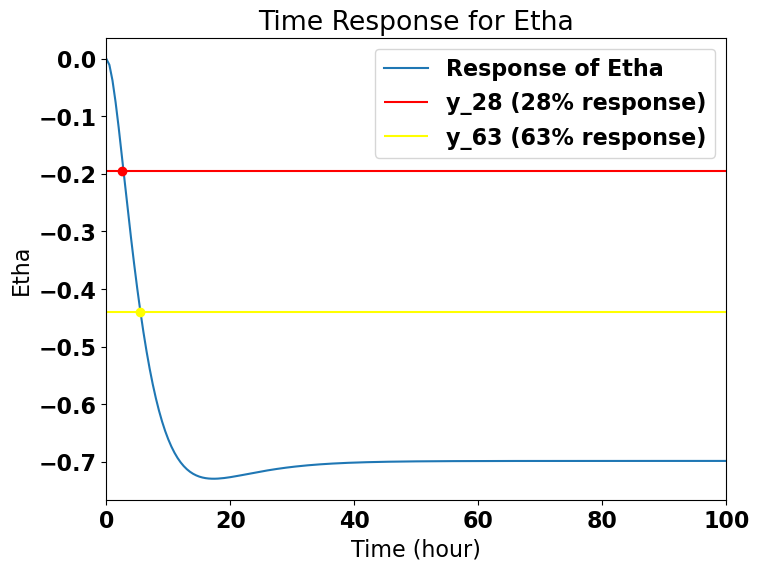

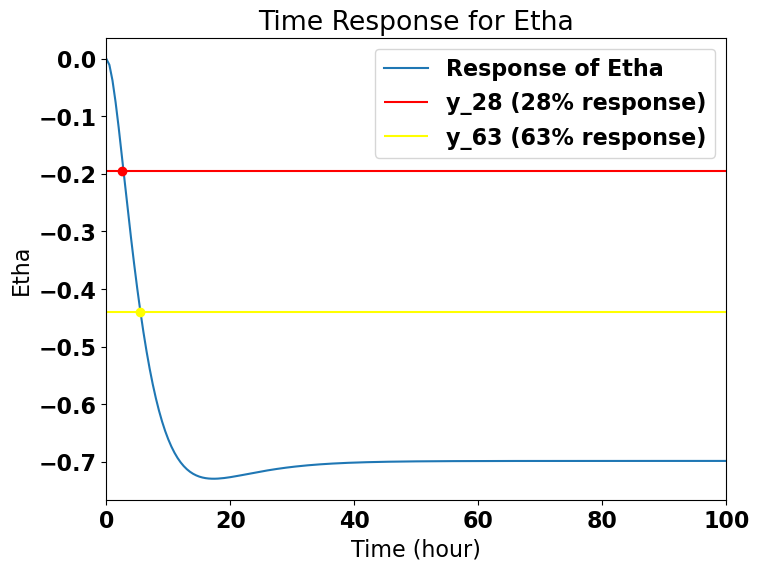

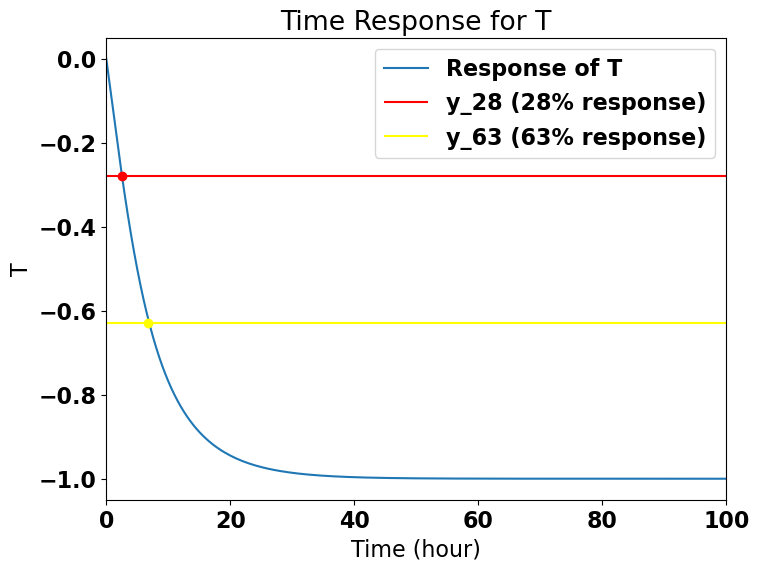

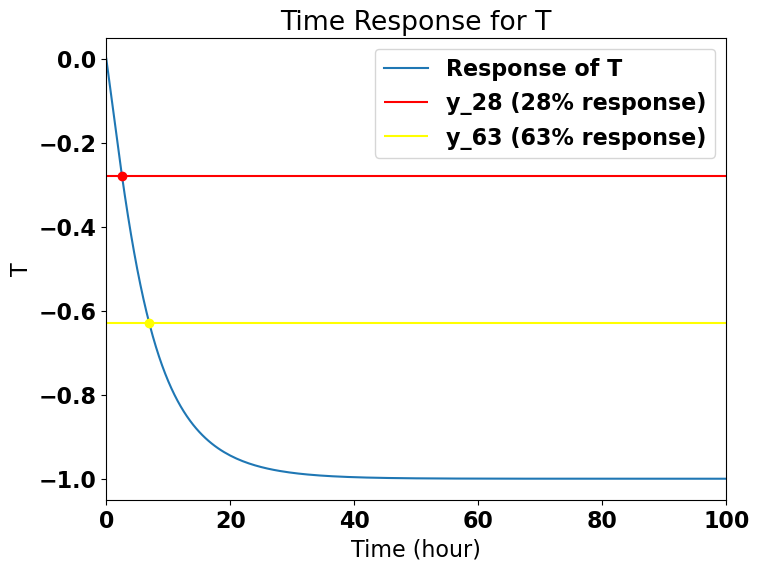


Transfer Function details for input mode "Qm":
Etha: {'Time 63 (hrs)': 5.5, 'Time 28 (hrs)': 2.5, 'kp': 0.6985637762700436, 'taup': 4.5, 'theta': -0.5}
T: {'Time 63 (hrs)': 6.83, 'Time 28 (hrs)': 2.5, 'kp': 0.999999998080435, 'taup': 6.495, 'theta': -1.83}


In [25]:
Qm_dict, Qm_data = data_time28_63_dict(deviation_dfs["Qm"], mode=1, sampling_period=0.5)

In [26]:
delay_list = [Qc_dict["Etha"]["theta"], Qm_dict["Etha"]["theta"], Qc_dict["T"]["theta"], Qm_dict["T"]["theta"]]
for i, value in enumerate(delay_list):
    if value < 0.0:
        delay_list[i] = 0.0
delay_list

[1.4000000000000004, 0.0, 0.0, 0.0]

In [27]:
A, B, C, D, y_dis_model_ss_ab_delay, tOut = state_space_form_using_matlab(Qc_dict, Qm_dict, delay_list, Qc_data, Qm_data)

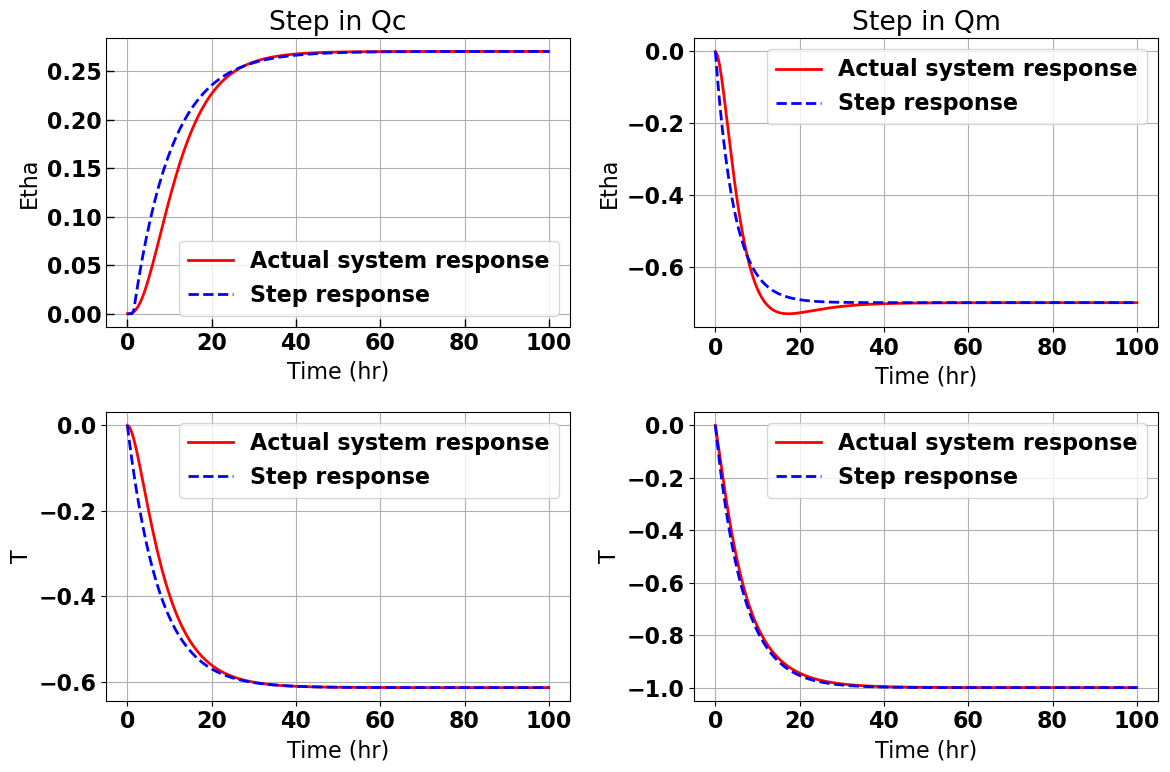

In [28]:
plot_results_statespace(tOut, y_dis_model_ss_ab_delay, Qc_data, Qm_data)

In [29]:
# Saving A, B, C matrices
system_dict = {"A": A,
               "B": B,
               "C": C}
data_dir = os.path.join(os.getcwd(), 'Data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
save_path = os.path.join(data_dir, "system_dict.pickle")

In [30]:
with open(save_path, 'wb') as file:
    pickle.dump(system_dict, file)

In [31]:
# Saving min max data
scaling_factor = {"min": data_min,
               "max": data_max}
save_path = os.path.join(data_dir, "scaling_factor.pickle")
with open(save_path, 'wb') as file:
    pickle.dump(scaling_factor, file)